# Semantic Deduplication on Text

GPU accelerated implementation of [SemDeDup: Data-efficient learning at web-scale through semantic deduplication](https://arxiv.org/abs/2303.09540)  

In [ ]:
import os

os.environ["LOGURU_LEVEL"] = "ERROR"

import pandas as pd

input_path_to_data = "/path/to/data"
semantic_out_dir = os.path.abspath("./output/e2e")
output_path = os.path.join(semantic_out_dir, "output")
cache_path = os.path.join(semantic_out_dir, "cache")
input_filetype = "parquet"  # this can be either of jsonl or parquet
output_filetype = "parquet"  # this can be either of jsonl or parquet

## Running as a single stage (e2e)

The workflow does all of things behind the scenes
1. Read original dataset
2. Run Embedding Generation 
3. Use KMeans to cluster the embeddings
4. Compute pairwise similarity inside each of the clusters
5. Identify duplicates based on `eps` provided (and `ranking_strategy`)
6. Remove duplites from the original dataset

We also allow users to also run these steps indepedently, which can be seen in the tutorial semantic_step_by_step.ipynb [TODO: Can we add link to it?]


In [2]:
from nemo_curator.stages.deduplication.semantic import RankingStrategy
from nemo_curator.stages.text.deduplication.semantic import TextSemanticDeduplicationWorkflow

workflow = TextSemanticDeduplicationWorkflow(
    input_path=input_path_to_data,
    output_path=output_path,
    cache_path=cache_path,
    perform_removal=True,
    # Embedding generation parameters
    text_field="text",
    model_identifier="sentence-transformers/all-MiniLM-L6-v2",
    embedding_max_seq_length=512,
    embedding_max_chars=None,
    embedding_pooling="mean_pooling",
    embedding_model_inference_batch_size=256,
    # Semantic deduplication parameters
    n_clusters=100,  # this number can be much higher when the data is large
    # For large scale data we should use CURATOR_DEDUP_ID_STR if we are
    # also performing removal.
    id_field="id",
    eps=0.01,
    # K-means clustering parameters
    ranking_strategy=RankingStrategy(metadata_cols=["cosine_dist_to_cent"], ascending=True),
    pairwise_batch_size=1024,
    # ID generator parameters
    # For large scale data we should set use_id_generator to True if we are performing removal.
    use_id_generator=False,
    id_generator_state_file=None,
    # I/O parameters
    input_filetype=input_filetype,
    input_files_per_partition=1,
    output_filetype=output_filetype,
    verbose=True,
    clear_output=True,
)

In [3]:
from nemo_curator.core.client import RayClient

client = RayClient(num_cpus=64, num_gpus=4)
client.start()
try:
    workflow.run()
finally:
    client.stop()

2025-09-16 11:59:48,062	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 11:59:48,065	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...


2025-09-16 11:59:49,211	INFO usage_lib.py:447 -- Usage stats collection is disabled.
2025-09-16 11:59:49,211	INFO scripts.py:913 -- Local node IP: 127.0.1.1


2025-09-16 11:59:52,222	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


2025-09-16 11:59:52,148	SUCC scripts.py:949 -- --------------------
2025-09-16 11:59:52,148	SUCC scripts.py:950 -- Ray runtime started.
2025-09-16 11:59:52,148	SUCC scripts.py:951 -- --------------------
2025-09-16 11:59:52,148	INFO scripts.py:953 -- Next steps
2025-09-16 11:59:52,148	INFO scripts.py:956 -- To add another node to this Ray cluster, run
2025-09-16 11:59:52,148	INFO scripts.py:959 --   ray start --address='127.0.1.1:6379'
2025-09-16 11:59:52,148	INFO scripts.py:968 -- To connect to this Ray cluster:
2025-09-16 11:59:52,148	INFO scripts.py:970 -- import ray
2025-09-16 11:59:52,148	INFO scripts.py:971 -- ray.init(_node_ip_address='127.0.1.1')
2025-09-16 11:59:52,148	INFO scripts.py:983 -- To submit a Ray job using the Ray Jobs CLI:
2025-09-16 11:59:52,148	INFO scripts.py:984 --   RAY_API_SERVER_ADDRESS='http://127.0.0.1:8265' ray job submit --working-dir . -- python my_script.py
2025-09-16 11:59:52,148	INFO scripts.py:993 -- See https://docs.ray.io/en/latest/cluster/running

2025-09-16 11:59:52,917	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 11:59:52,919	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 11:59:52,919	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 29495.81it/s]
2025-09-16 12:03:06,910	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:03:06,912	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:03:06,919	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


(KMeansReadFitWriteStage pid=1854069) 203520000
(KMeansReadFitWriteStage pid=1854070) 203323776
(KMeansReadFitWriteStage pid=1854071) 203520000
(KMeansReadFitWriteStage pid=1854072) 203520000


2025-09-16 12:03:35,546	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:03:35,548	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:03:35,554	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 12:03:35,581	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:03:35,583	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:03:35,583	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
2025-09-16 12:04:02,497	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:04:02,498	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:04:02,505	INFO worker.py:1942 -- Connected to Ray cluster. View th

### Looking at output / cache paths

#### Embeddings

1. `id` : The id field from our original dataset. 
    - For all subsequent steps this is assumed to be the  `id_field`
    - If you had set `use_id_generator` to `True` then instead of this you would see the `_curator_dedup_id` spcified. 
        - The id in that field is generated using our IdGenerator which assigns integer ids to each row in input data that later is used in removal. 
2. `embeddings` : The embedding generated by the model we used above.

In [4]:
embeddings_path = os.path.join(cache_path, "embeddings")

pd.read_parquet(os.path.join(embeddings_path, os.listdir(embeddings_path)[0])).head()

,id,embeddings
0,TinyStories-train.txt-1050000,"[-0.03838138282299042, 0.047589678317308426, 0..."
1,TinyStories-train.txt-1050001,"[0.012109456583857536, 0.05599193274974823, 0...."
2,TinyStories-train.txt-1050002,"[-0.021665604785084724, 0.06978840380907059, 0..."
3,TinyStories-train.txt-1050003,"[-0.07565540075302124, -0.032156478613615036, ..."
4,TinyStories-train.txt-1050004,"[-0.016478808596730232, 0.07793284207582474, 0..."


#### KMeans Results

1. `id` : The ids of the rows that belong to the cluster.
2. `embeddings` : These are later used for pairwise similarity
3. `l2_dist_to_cent` / `cosine_dist_to_cent` : This represents how far (l2 distance or cosine distance) is from our clusters centroid.
    - These fields help us define how we want to prioritize ranking within our cluster. See `RankingStratergy`
    - If we had other `metadata_fields` provided they would be used here instead.


In [5]:
kmeans_path_first_centroid = os.path.join(cache_path, "semantic_dedup", "kmeans_results", "centroid=0")

pd.read_parquet(os.path.join(kmeans_path_first_centroid, os.listdir(kmeans_path_first_centroid)[0])).head()

,id,embeddings,l2_dist_to_cent,cosine_dist_to_cent
0,TinyStories-train.txt-1320022,"[-0.056338035, 0.05346775, 0.03180039, -0.0028...",0.734287,0.314044
1,TinyStories-train.txt-1321453,"[-0.058759537, 0.0917165, 0.057991754, 0.01050...",0.629261,0.222772
2,TinyStories-train.txt-1321597,"[-0.023847684, 0.036328573, 0.025864411, 0.090...",0.608941,0.206736
3,TinyStories-train.txt-1321609,"[-0.09930863, 0.08990324, 0.020131571, -0.0005...",0.551234,0.164066
4,TinyStories-train.txt-1321616,"[-0.07285272, 0.058476895, 0.026692118, -0.011...",0.683624,0.268260


#### Pairwise Similarity Result

1. `id` : The identifier for the duplicate row.
2. `max_id` : The closest pair for the duplicate row.
3. `cosine_sim_score` : The cosine similarity between the two points


In [6]:
pairwise_path = os.path.join(cache_path, "semantic_dedup", "pairwise_results")

pd.read_parquet(os.path.join(pairwise_path, "cluster_0.parquet")).head()

,id,max_id,cosine_sim_score
0,TinyStories-train.txt-2036969,TinyStories-train.txt-2036969,0.000000
1,TinyStories-train.txt-578142,TinyStories-train.txt-2036969,0.832831
2,TinyStories-train.txt-2108502,TinyStories-train.txt-578142,1.000000
3,TinyStories-train.txt-649801,TinyStories-train.txt-2036969,0.863873
4,TinyStories-train.txt-899672,TinyStories-train.txt-649801,1.000000


##### Visualizing Similarity in our dataset

Depending on our dataset size we can read through all of the files and plot how much data is similar to one another.
Here we show how to read file by file and then perform a reduce. 

In our dataset we can see that ~20% of our data has cosine_similarity of 0.9 or more.

Based on the analysis here we can decide what our `eps` should be. 
However in this tutorial we pre-ran with eps set and perform_removal to be True.

However ideally, users do this analysis, inspect the duplicates, come up with an `eps` and then run a pipeline that includes the `IdentifyDuplicates` stage.

And finally perform removal.

**NOTE : If you run with `use_id_generator=False` (which affects removal performance at large scale) you will see the actual ids of instead of the int ids. You can then also inspect the original dataset for those ids, and that can also help your decision for `eps`**

In [7]:
from collections import Counter
from functools import reduce

import numpy as np


def get_bins(df: pd.DataFrame, num_bins: int = 1_000) -> dict[float, int]:
    bins = np.linspace(0, 1.01, num_bins)

    return Counter(
        pd.cut(df["cosine_sim_score"], bins=bins, labels=bins[1:], retbins=False, include_lowest=True, right=True)
        .value_counts()
        .to_dict()
    )


similarity_across_dataset = reduce(
    lambda x, y: x + y,
    [
        get_bins(pd.read_parquet(os.path.join(pairwise_path, f), columns=["cosine_sim_score"]), num_bins=1000)
        for f in os.listdir(pairwise_path)
    ],
)

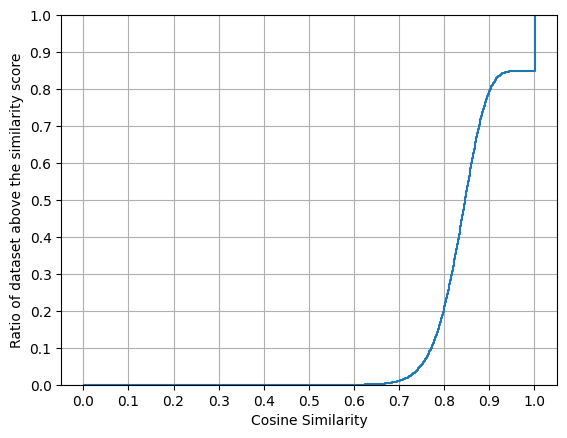

In [8]:
import matplotlib.pyplot as plt

plt.ecdf(x=similarity_across_dataset.keys(), weights=similarity_across_dataset.values())
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("Cosine Similarity")
plt.ylabel("Ratio of dataset above the similarity score")
plt.grid()
plt.show()

#### Looking at duplicates

- `id` : This is a list of all ids that are above our similarity threshold `eps`.

In [9]:
duplicates_path = os.path.join(output_path, "duplicates")

pd.read_parquet(os.path.join(duplicates_path, os.listdir(duplicates_path)[0])).head()

,id
0,TinyStories-train.txt-1000109
1,TinyStories-train.txt-1000111
2,TinyStories-train.txt-1000112
3,TinyStories-train.txt-1000117
4,TinyStories-train.txt-1000119


#### Looking at deduplicated dataset

Here we see all the original columns. 

We can control the schema of this by specifying the `output_fields` arg in the workflow definition.

If you had set use_id_generator then you'd see `_curator_dedup_id` here as well.

In [10]:
deduplicated_path = os.path.join(output_path, "deduplicated")

pd.read_parquet(os.path.join(deduplicated_path, os.listdir(deduplicated_path)[0])).head()

,text,filename,id
0,Once upon a time there was a frog. He lived i...,TinyStories-train.txt,TinyStories-train.txt-100000
1,Once there was a tired mule. He was tired fro...,TinyStories-train.txt,TinyStories-train.txt-100001
2,"Once upon a time, there was a big family. Eve...",TinyStories-train.txt,TinyStories-train.txt-100002
3,"One day, a young girl was singing in the park...",TinyStories-train.txt,TinyStories-train.txt-100003
4,"One day, Timmy was excited to learn something...",TinyStories-train.txt,TinyStories-train.txt-100004
